분석 목적
1. 미국 포드사에서 제공한 데이터셋을 사용하여 개발한 AI모델로 시스템/설비 예지 보전을 위해, 자동차 시스템 시계열 데이터셋에 대해 분류 알고리즘을 적용하여 불량 제품을 분류하고자 한다.
2. 제조업 설비 내의 여러 개의 계측 센서가 시간 순서대로 측청한 값으로 이루어진(행: 시간, 열: 센서의 종류) 시계열 데이터(Time Series Data)에 대해, 설비의 정상/비정상을 판단하는 분류 문제(Classification Task)를 해결하고자 한다.
3. 도메인 지식이 없는 분석 실무자도 기계학습 기반의 정상/비정상 분류 과제를 수행할 수 있도록 한다. 

데이터셋 형태 
1. Sensor 1~500
2. 데이터 개수 : 4,921개

공정 개요
1. 자동차 시스템이며, 자동차 하위 시스템인 엔진의 (정상 / 비정상) 상태와 연관이 있을 수 있는 주변의 500개 센서들로 여러 요소(i.e. 소음, 압력, 진동, 온도 등)들을 측정한다. 

AI 기반 예측 모델 개발 배경
1. 제조업 현장에서 분석 수요가 높은 시스템/설비 정상/비정상 상태 분류 그리고 예지 보전(Predictive Maintenance)을 위해, 현업의 인공지능에 대한 사전지식이 많지 않은 사람도 사용 할 수 있는 모델을 만들고자 한다.
2. 자동차 하위 시스템인 엔진의 이상 여부를 분류하는 문제 해결을 통해, 제조업 현장내에서의 각종 시스템(i.e. 운영 설비, 운영 시스템 등)으로 확장/응용하여 해결하고자 하는 문제에 대한 접근 방법을 쉽게 제시하고자 한다.
3. 제조업 현업 전문가들이 각자 보유하고 있는 데이터에 대하여 이 모델을 적용하여, 데이터 기반의 의사 결정을 통한 현업의 생산력 증진, 정비 능력 향상에 기여하고자 한다. 


- 동일 시간 길이(3,600) 내 센서 값들이 넓은 범위로 퍼져있다.

- 변수 간의 Scale이 서로 다르기 때문에, 데이터를 그대로 학습하는 것은 적절하지 않다.

- 인풋 값들을 정규화(Normalization)을 한다.

- 흔히 공정 데이터에는 이상치(Outlier)가 발생할 수 있는데 강건한 정규화가 필요할 때 RobustScaler를 사용한다.

- StandScaler는 보다 더 일반적으로 사용하는 정규화 방법

    - 데이터를 단위 분산으로 조정함으로써 Outlier에 취약할 수 있음     

- RobustScaler는 Feature간 스케일을 갖게 되지만 평균과 분산 대신 중간 값(median)과 사분위값(quartile)을 사용 -> 극단값(Outlier)에 영향을 받지 않음

In [6]:
import itertools
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from sklearn.preprocessing import StandardScaler, RobustScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 1.데이터 로드 / 전처리

## 1)데이터 파일 설정

In [7]:
file_path = './dataset/'
train_fn = 'FordA_TRAIN.arff'
test_fn = 'FordA_TEST.arff'

## 2)ARFF 파일 읽는 함수 정의

In [ ]:
def read_ariff(path):
    raw_data, meta = loadarff(path)
    cols = [x for x in meta]
    data2d = np.zeros([raw_data.shape[0], len(cols)])

    for i, col in zip(range(len(cols)), cols):
        data2d[:, i]=raw_data[col]
    return data2d

## 3)학습 및 테스트 데이터 로드

In [8]:
train =  read_ariff(file_path + train_fn)
test = read_ariff(file_path + test_fn)

print('train_set.shape:', train.shape)
print('test_set.shape:', test.shape)

train_set.shape: (3601, 501)
test_set.shape: (1320, 501)


In [9]:
x_train_temp = train[:,:-1]
y_train_temp = train[:,-1]

x_test = test[:, :-1]
y_test = test[:, -1]

## 4)정상 및 비정상 데이터 분리

In [10]:
normal_x = x_train_temp[y_train_temp==1]
abnormal_x = x_train_temp[y_train_temp==-1]
normal_y = y_train_temp[y_train_temp==1]
abnormal_y = y_train_temp[y_train_temp==-1]

## 5)학습 및 검증 데이터로 분할

In [ ]:
x_train_normal, x_valid_normal, y_train_normal, y_valid_normal = train_test_split(
    normal_x, normal_y, test_size=0.2, random_state=42, stratify=normal_y)

x_train_abnormal, x_valid_abnormal, y_train_abnormal, y_valid_abnormal = train_test_split(
    abnormal_x, abnormal_y, test_size=0.2, random_state=42, stratify=abnormal_y)

## 6)정상 및 비정상 데이터를 결합

In [ ]:
x_train = np.concatenate((x_train_normal, x_train_abnormal), axis=0)
y_train = np.concatenate((y_train_normal, y_train_abnormal), axis=0)

x_valid = np.concatenate((x_valid_normal, x_valid_abnormal), axis=0)
y_valid = np.concatenate((y_valid_normal, y_valid_abnormal), axis=0)

In [11]:
print('x_train.shape:', x_train.shape)
print('x_valid.shape:', x_valid.shape)
print('y_train.shape:', y_train.shape)
print('y_valid.shape:', y_valid.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (2880, 500)
x_valid.shape: (721, 500)
y_train.shape: (2880,)
y_valid.shape: (721,)
x_test.shape: (1320, 500)
y_test.shape: (1320,)


## 7)데이터 스케일링

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

stder = StandardScaler()
stder.fit(x_train)
x_train = stder.transform(x_train)
x_valid = stder.transform(x_valid)

# rscaler = RobustScaler()
# rscaler.fit(x_train)
# x_train = rscaler.transform(x_train)
# x_valid = rscaler.transform(x_valid)

## 8)레이블 변환

In [ ]:
y_train[y_train == -1] = 0
y_valid[y_valid == -1] = 0
y_test[y_test == -1] = 0

In [ ]:
# for RNN, CNN
x_train_exp = np.expand_dims(x_train, -1)
x_valid_exp = np.expand_dims(x_valid, -1)
x_test_exp = np.expand_dims(x_test, -1)

# x_train_exp = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_valid_exp = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], 1))
# x_test_exp = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print('x_train_exp의 형태:', x_train_exp.shape)
print('x_valid_exp의 형태:', x_valid_exp.shape)
print('x_test_exp의 형태:', x_test_exp.shape)

x_train_exp의 형태: (2880, 500, 1)
x_valid_exp의 형태: (721, 500, 1)
x_test_exp의 형태: (1320, 500, 1)


## 2.데이터 시각화

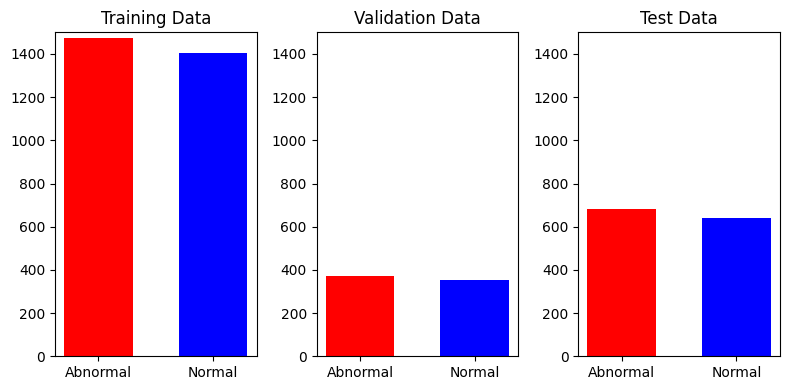

In [12]:
# 1. 데이터 불균형 확인
# Class의 종류 확인 : 정상 1, 비정상 -1
classes = np.unique(np.concatenate((y_train, y_test), axis=0))
# classes = array([-1,1])

# Plot의 X축의 개수
x = np.arange(len(classes))
# Plot의 X축의 이름
labels = ['Abnormal','Normal']

# Train 데이터의 정상/비정상 각 총 개수
values_train = [(y_train == i).sum() for i in classes]
# Valid 데이터의 정상/비정상 각 총 개수
values_valid = [(y_valid == i).sum() for i in classes]
# Test 데이터의 정상/비정상 각 총 개수
values_test = [(y_test == i).sum() for i in classes]

# Plot Figure의 Size 설정 (8X4)
plt.figure(figsize=(8,4))

# Plot Figure내 3개의 subplot 중 첫 번째(왼쪽) 지정
plt.subplot(1,3,1)
plt.title('Training Data')
# Train 데이터의 정상/비정상 개수 BarPlot
plt.bar(x, values_train, width=0.6, color=['red','blue'])
plt.ylim([0, 1500]) # y축의 범위 설정
plt.xticks(x, labels) # x축의 눈금 위치와 눈금 레이블 설정

# Plot Figure내 3개의 subplot 중 두 번째(가운데) 지정
plt.subplot(1,3,2)
plt.title('Validation Data')
# Valid 데이터의 정상/비정상 개수 BarPlot
plt.bar(x, values_valid, width=0.6, color=['red','blue'])
plt.ylim([0, 1500])
plt.xticks(x, labels)

# Plot Figure내 3개의 subplot 중 세 번째(오른쪽) 지정
plt.subplot(1,3,3)
plt.title('Test Data')
# Test 데이터의 정상/비정상 개수 BarPlot
plt.bar(x, values_test, width=0.6, color=['red','blue'])
plt.ylim([0, 1500])
plt.xticks(x, labels)

plt.tight_layout() # 자동 간격 조정
plt.savefig('data_imblance.png', dpi=100, bbox_inches='tight')
plt.show()

> 출력 결과 정상 Label의 데이터 수와 비정상 Label의 데이터 수가 비교적 균형적인 편이다

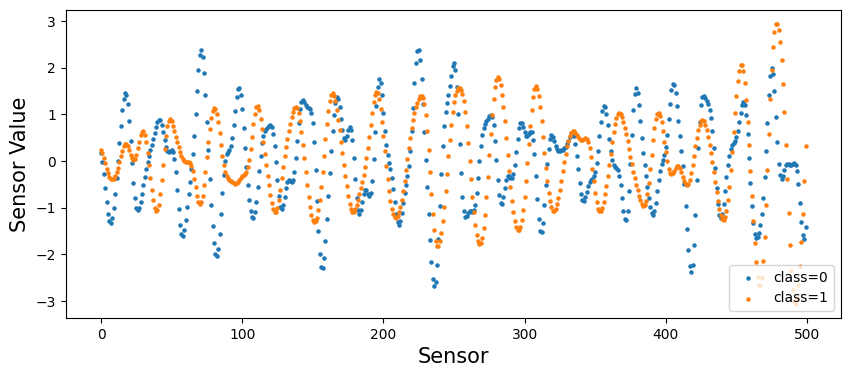

In [13]:
# 2. 정상/비정상 데이터 간의 차이
# 무작위의 시간대로 선택한 정상과 비정상 간의 센서 값의 분포 차이 
import random

labels = np.unique(np.concatenate((y_train, y_test), axis=0))
# labels (-1 or 1)

plt.figure(figsize=(10,4))

for c in labels:
    c_x_train = x_train[y_train == c]
    # 비정상 클래스 -1 -> 0으로 변경 
    if c == -1 : c = c + 1
    # 무작위 선택
    time_t =random.randint(0, c_x_train.shape[0])
    # 산점도 : x축에 0~499, 
    # 500개의 센서데이터, 
    # c_x_train배열에서 랜덤으로 선택된 time_t번째 센서 데이터, 
    # 각 클래스에 대한 레이블 지정,
    # 마커 스타일 o, 크기 5
    plt.scatter(range(0,500), c_x_train[time_t], label='class='+str(int(c)), marker='o', s=5)

plt.legend(loc='lower right') # 그래프의 범례 오른쪽 아래 위치
plt.xlabel('Sensor', fontsize=15) # 센서 번호
plt.ylabel('Sensor Value', fontsize=15) # 센서 값
plt.savefig('ford_data_ts_sample1.png', dpi=100, bbox_inches='tight') # 여백 최소화
plt.show()

비정상 Label 데이터 수:  1476


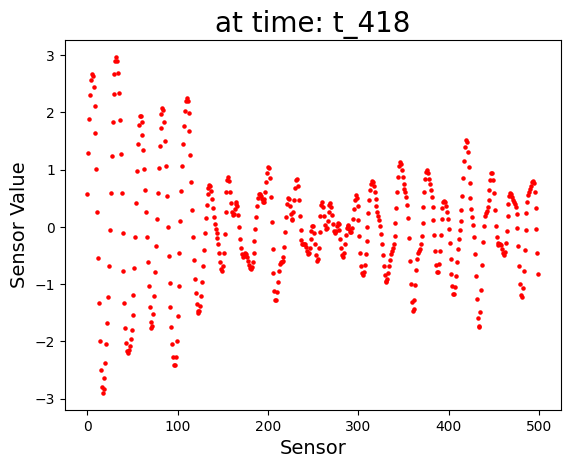

정상 Label 데이터 수:  1404


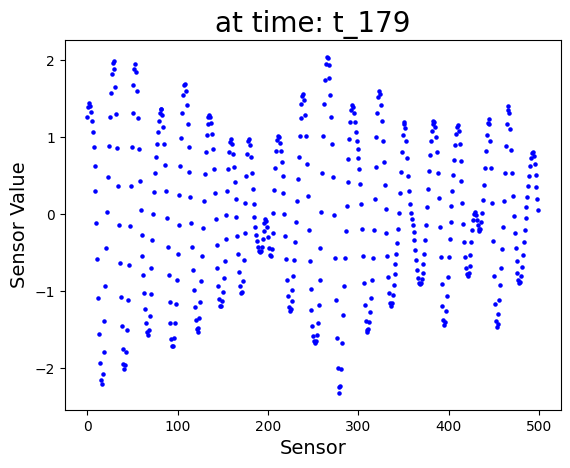

In [14]:
# 3. 정 상/비정상 샘플 각각 출력
def get_scatter_plot(c):
    time_t = random.randint(0, c_x_train.shape[0])

    plt.scatter(range(0, c_x_train.shape[1]), c_x_train[time_t],
                marker='o', s=5, c='r' if c == -1 else 'b')
    plt.title(f'at time: t_{time_t}', fontsize=20)
    plt.xlabel('Sensor', fontsize=14)
    plt.ylabel('Sensor Value', fontsize=14)
    plt.savefig('{state}.png'.format(state='abnormal'if c == -1 else 'normal'),
                dpi = 100, bbox_inches = 'tight')
    plt.show()

labels = np.unique(np.concatenate((y_train, y_test), axis=0))

for c in labels:
    c_x_train = x_train[y_train == c]
    if c == -1:
        print('비정상 Label 데이터 수: ', len(c_x_train))
        get_scatter_plot(c)
    else:
        print('정상 Label 데이터 수: ', len(c_x_train))
        get_scatter_plot(c)

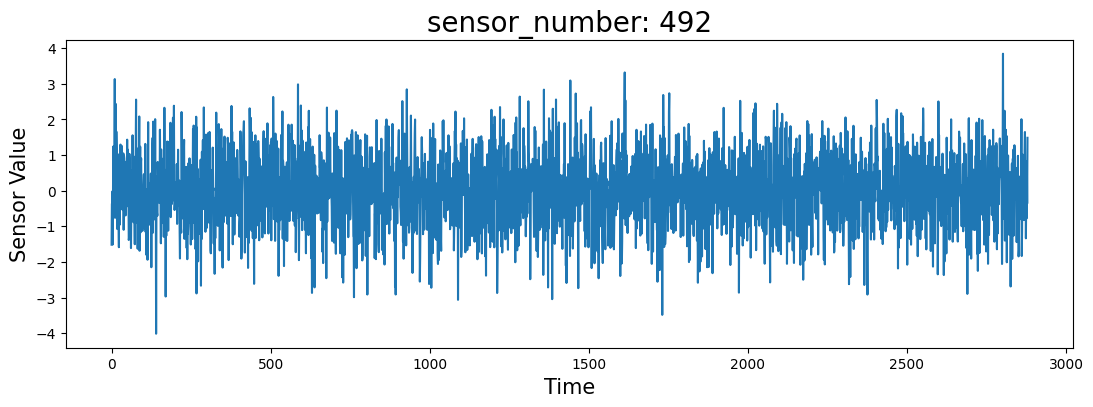

In [15]:
# 0~500번 사이의 랜덤으로 뽑은 센서의 시계열 데이터 값
sensor_number = random.randint(0, 500)
plt.figure(figsize=(13,4))
plt.title(f'sensor_number: {sensor_number}', fontsize=20)
plt.plot(x_train[:, sensor_number])
plt.xlabel('Time', fontsize=15)
plt.ylabel('Sensor Value', fontsize=15)
plt.savefig('ford_a_sensor.png', dpi=100, bbox_inches='tight')
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8316\2329740616.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet', 31)


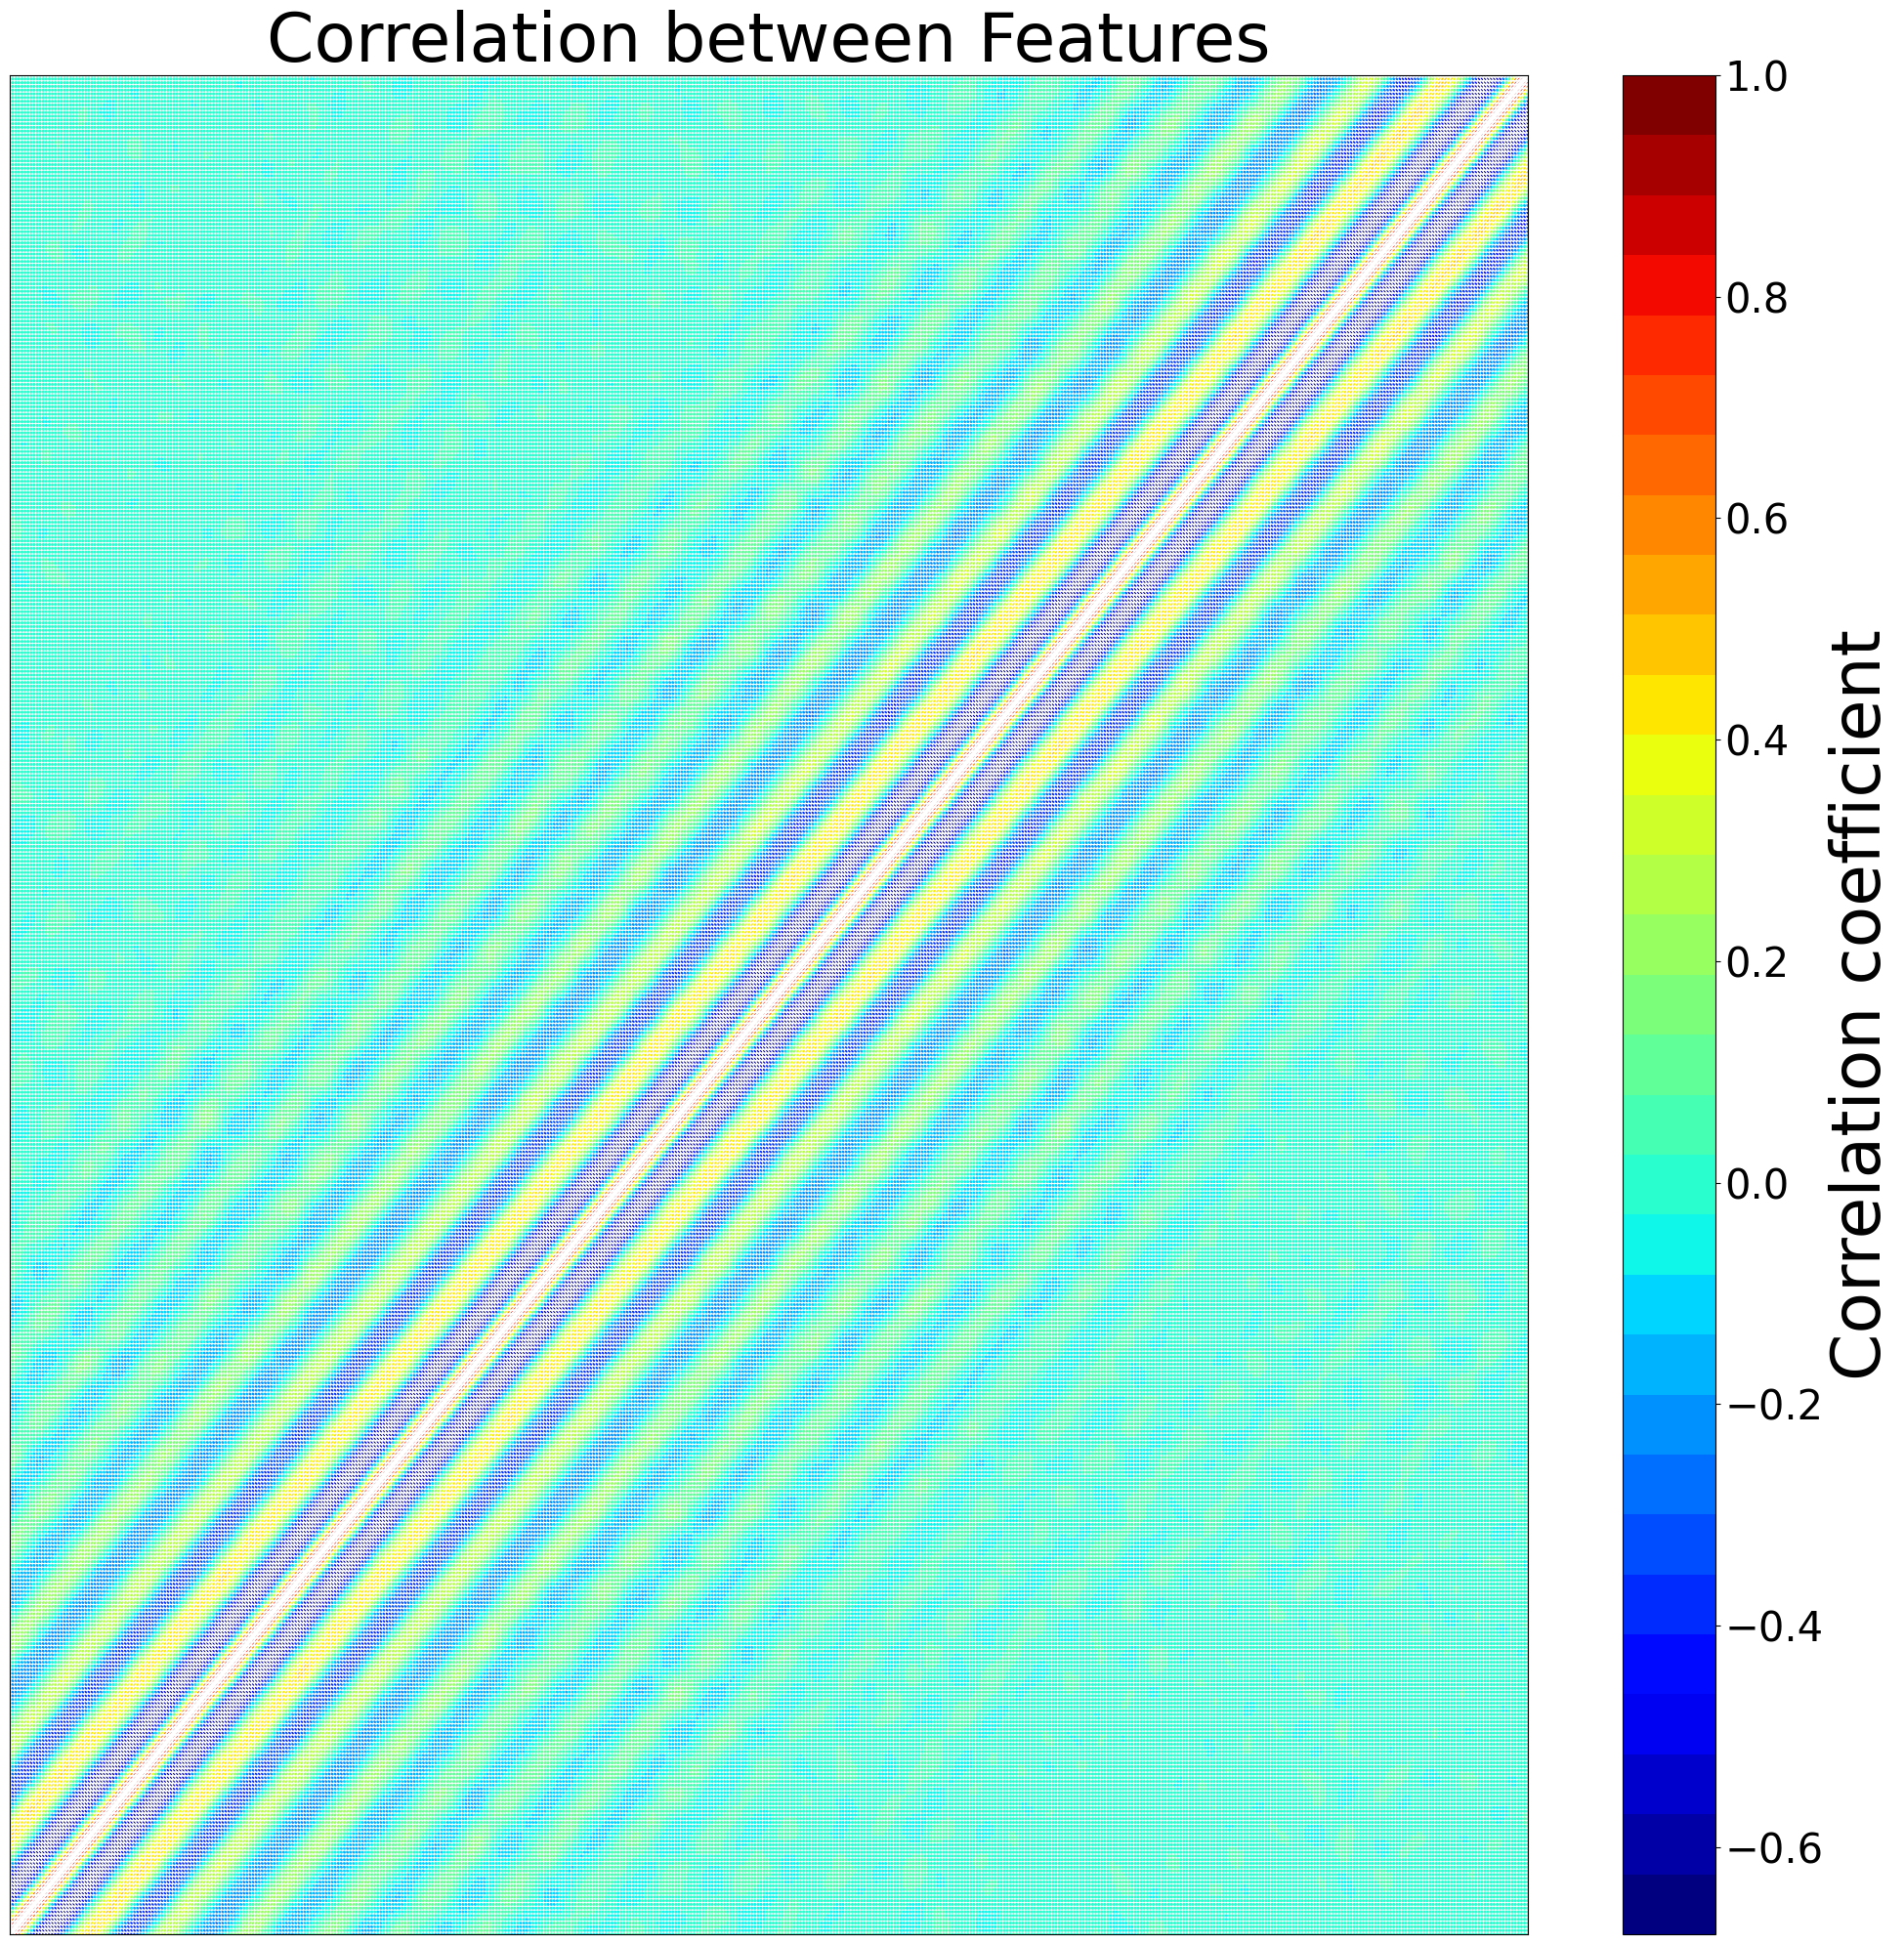

In [26]:
import matplotlib.cm as cm
from matplotlib.collections import EllipseCollection

df = pd.DataFrame(data = x_train,
                  columns= ['sensor_{}'.format(label+1) for label in range(x_train.shape[1])])
data = df.corr()

def plot_corr_ellipses(data, ax=None, **kwargs):

    M = np.array(data)
    if not M.ndim ==2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1,1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] -0.5)
        ax.set_ylim(-0.5, M.shape[1] -0.5)

    xy = np.indices(M.shape)[::-1].reshape(2,-1).T

    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(
        widths=w, 
        heights=h, 
        angles=a, 
        units='x',
        offsets=xy, 
        transOffset=ax.transData, 
        array=M.ravel(),
        **kwargs
    )
    
    ax.add_collection(ec)

    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90, fontsize=100)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index, fontsize=100)
    return ec

fig, ax = plt.subplots(1,1,figsize=(20,20))
cmap = cm.get_cmap('jet', 31)
m = plot_corr_ellipses(data, ax=ax, cmap=cmap)

cb = fig.colorbar(m)
cb.set_label('Correlation coefficient', fontsize=50)
cb.ax.tick_params(labelsize=30) 
plt.title('Correlation between Features', fontsize=50)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tight_layout()

plt.savefig('corr.png', dpi=100, bbox_inches='tight')
plt.show()

> 센서 번호가 가까울수록 상관성이 높다.

> 거리가 멀어질수록 상관성이 줄어드는 것을 확인할 수 있다.

> Local한 특징(근처 센서 간의 관계)을 학습하는 모델(i.e.CNN)이 좋은 성능을 보일 수 있을 것이라 예상해볼 수 있다. 

#### 3.지표함수

##### (1) Confustion Matrix

In [ ]:
def draw_confusion_matrix(model, xt, yt, model_name):
    y_pred = model.predict(xt)
    plt.figure(figsize=(3, 3))
    cm = confusion_matrix(yt, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])
    thresh = cm.max() / 2
    fmt = 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_cm.png', dpi=100, bbox_inches='tight')
    plt.show()
    print(classification_report(yt, y_pred))

##### (2) ROC Curve

In [ ]:
def draw_roc(model, xt, yt, model_name):
    y_pred_proba = model.predict_proba(xt)[:, 1]
    fpr, tpr, _ = roc_curve(yt, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(f'{model_name}_roc.png', dpi=100, bbox_inches='tight')
    plt.show()

##### (3) Epoch에 따른 학습 & 검증의 손실(loss) 그래프


In [ ]:
def plot_loss_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training & Validation Loss')
    plt.ylabel('loss', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}.png', dpi=100, bbox_inches='tight')
    plt.show()

##### (4) Epoch에 따른 정확도(Accuracy Rate) 그래프

In [ ]:
def plot_prediction_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val'+'sparse_categorical_accuracy'])
    plt.title('model'+'Prediction Accuracy')
    plt.ylabel('sparse_categorical_accuracy', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}.png', dpi=100, bbox_inches='tight')
    plt.show()